### DU Jack | SIA

# Bayesian Networks

This TP provides an excellent opportunity to gain further exposure to relevant topics and applications of Bayesian Networks (diagnosis, prediction, etc.).

Objectives: Students will be able to:
- Create Bayesian Networks.
- Learn Bayesian Networks from real-world problems and datasets.
- Determine inferences from Bayesian Networks.

Technology Requirements:
- Linux (windows user may install virtual machines)
- Python 3.8 or higher (due to pgmpy compatibility)
- Download and install pip and then install pgmpy:
   `$ pip install pgmpy`
- If the previous did not work, this can be done manually after downloading the code source:

```
$ git clone https://github.com/pgmpy/pgmpy
$ cd pgmpy/
$ sudo pip install -r requirements.txt
$ sudo python setup.py install
```


*Note: if you encountered problems installing pip or pgmpy, refer to the pgmpy Installation Page: https://pgmpy.org/started/install.html

In [2]:
#!pip install pgmpy

In [3]:
import pgmpy
import pgmpy.models
import pgmpy.inference
import pgmpy.estimators
import pgmpy.inference

import networkx as nx
import matplotlib.pyplot
import xgboost

import pandas as pd
import time

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

## Part 0: Building a model from scratch: Monty Hall Problem

You might know about the famous Monty Hall, or three doors problem (https://en.wikipedia.org/wiki/Monty_Hall_problem). This is a TV game where a contestant $Contestant$ interacts with a host $Host$ to find a price $Price$ hidden behind one of three closed doors. The contestant makes a first choice of one door they would like to open. The host will then help the contestant by opening one of the doors, leaving the contestant to choose again amongst 2 doors. If the chosen door hides the price, the constestant wins.

The host rules for choosing a door to open are:
 - never open the door behind which the price is hidden
 - never open the door chosen by the contestant

A mathematician states: "Selecting in the second step the door that wasn't chosen in the first step, has a 66% probability of granting the price to the contestant". We want to use Bayesian Network modeling to affirm or infirm this statement.

We will model this problem with a three states Bayesian Network.
 - $Contestant$ is a random variable with 3 possible values (the first chosen door by the contestant)
 - $Price$ is a random variable with 3 possible values (the price door)
 - $Host$ is a random variable with 3 possible values (the opened door by the host)

The price is placed before the contestant make its first choice, and the contestant has no indication on its location.


**Question**: From your understanding of the statement, write the independence and conditional independence relations you expect about $Contestant, Price, Host$, in the form "X indep Y" or "X indep Y | Z". (*A relation "X indep Y" means that X and Y value are set independently, without any link or interaction. A relation "X indep Y | Z" means that X and Y have been chosen with respect to a same information which is the value of Z, but other than that, there is no further link between the value of X and Y.*)

- Contestant indep Price
- Host indep Contestant |Price
- Host indep Price | Contestant

**TODO 0.1** Instantiate an object you will name `monty_hall`, from the class `pgmpy.models.BayesianNetwork` (https://pgmpy.org/models/bayesiannetwork.html). Add edges with its `.add_edge` method, corresponding to each edge in the Monty Hall graph.

Run the cell after to visualize the network.

In [4]:
# TODO
monty_hall = pgmpy.models.BayesianNetwork()

monty_hall.add_edge('Price', 'Host')
monty_hall.add_edge('Contestant', 'Host')

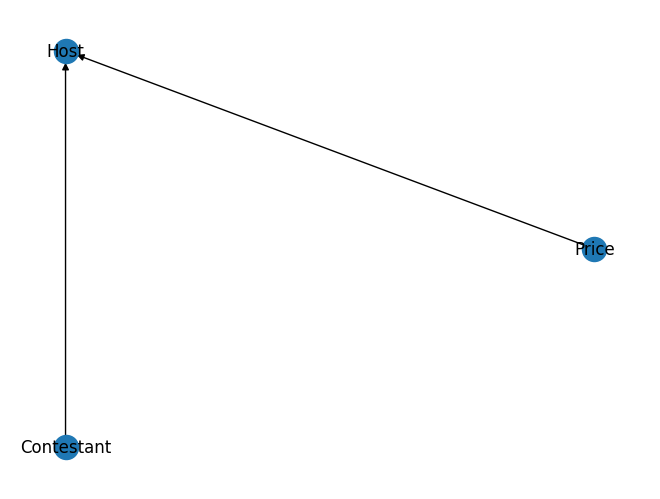

In [5]:
# RUN THIS CELL

def plot_bayesian_network(bn):

    # Convert to a directed graph for visualization
    G = nx.DiGraph(bn.edges())

    # Draw the graph
    nx.draw(G, with_labels=True, pos=nx.circular_layout(G))

plot_bayesian_network(monty_hall)

**TODO 0.2**: BayesianNetwork objects have a method that allows to find automatically the independence relations: `.get_independencies` (https://pgmpy.org/base/base.html). Verify that the relations encoded in the network match your answer to the first question.

If the relations differ, try to explain your reasoning (no point will be deducted for an explained incorrect answer).

In [6]:
# TODO
monty_hall.get_independencies()

(Price ⟂ Contestant)
(Contestant ⟂ Price)

Price and Contestant are correctly independant regarding the Monty Hall problem. <br>
- Price is randomly set behind a door.
- Contestant also randomly choose a door without having any information of the position of the price.

In the end, relations does not differ. However, Host is indeed dependant of Price and Contestant. 

Since we have specified the structure of the bayesian network in `monty_hall`, we must now provide the conditional probability distribution.

We assume that both $Contestant$ and $Price$ are chosen randomly (with probability uniformly $\frac13$).

**TODO 0.3** Use `pgmpy.factors.discrete.CPD.TabularCPD` (https://pgmpy.org/factors/discrete.html) to specify the conditional probability distribution of $Contestant$ and of $Price$. Name the TabularCPD of "Contestant" as `cpd_c` and "Price" as `cpd_p`.

Hint: a coin toss can be modeled by `TabularCPD("coin_toss", 2, [[0.5], [0.5]])`

The name of each variable (in first argument) must be identical to the corresponding node in the BayesianNetwork graph `montly_hall`.

In [7]:
# TODO
from pgmpy.factors.discrete import TabularCPD

cpd_c = TabularCPD("Contestant", 3, [[1/3], [1/3], [1/3]])

cpd_p = TabularCPD("Price", 3, [[1/3], [1/3], [1/3]])

# Output the CPDs
print("CPD for Contestant:")
print(cpd_c)
print("\nCPD for Price:")
print(cpd_p)

CPD for Contestant:
+---------------+----------+
| Contestant(0) | 0.333333 |
+---------------+----------+
| Contestant(1) | 0.333333 |
+---------------+----------+
| Contestant(2) | 0.333333 |
+---------------+----------+

CPD for Price:
+----------+----------+
| Price(0) | 0.333333 |
+----------+----------+
| Price(1) | 0.333333 |
+----------+----------+
| Price(2) | 0.333333 |
+----------+----------+


Run the following cell.

In [8]:
# RUN THIS CELL

cpd_h = pgmpy.factors.discrete.CPD.TabularCPD("Host",3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],  #Host=0
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],  #Host=1
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],  #Host=2
    ],
    evidence=["Contestant", "Price"],
    evidence_card=[3, 3])

cpd_h._truncate_strtable = lambda x: x  # prevents table truncating
print(cpd_h)

+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Contestant | Contestant(0) | Contestant(0) | Contestant(0) | Contestant(1) | Contestant(1) | Contestant(1) | Contestant(2) | Contestant(2) | Contestant(2) |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Price      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Host(0)    | 0.0           | 0.0           | 0.0           | 0.0           | 0.5           | 1.0           | 0.0           | 1.0           | 0.5           |
+------------+---------------+---------------+

**Question**: *From the table, what is the value of $\mathbb{P}(Host=0 | Contestant=1, Price=2)$? How do you interpret this value with respect to the problem setting?*

The probability is equal to: <br>
**$\mathbb{P}(Host=0 | Contestant=1, Price=2)$ = 1**
This is the probability that Host always choose the door '0' if the price is on door '2' and that Contestant firstly choose the door '1'. Due to the rules of the game, this is always the case and this probability is right.

**Question**: *How many numerical parameters in total were created to build this Bayesian Network? How many would be needed to create the entire joint probability table of $\mathbb{P}(Contestant, Price, Host)$?* 
- 2 are needed for Contestant and Price, the 3rd could be find by normalization as we have a probability system. 
However, for Host, as it's dependant of Price and Contestant, the system is defined as 3*3 = 9 outputs, and the system can be defined as 9*2 = 18 parameters. (the 3rd can be as the others defined by normalization). In total, there are 18+2+2 = 22 numerical parameters to create the Bayesian Network.

- To create the entire joint probability table, we would need 27 parameters in total as it is seen above.


Run the following cell to add the probability tables to the `monty_hall` object.

In [9]:
# RUN THIS CELL

# We now add the conditional probability distributions (cpd) to the bayesian network.

monty_hall.add_cpds(cpd_c, cpd_p, cpd_h)

# Verify that the model is correctly specified

assert monty_hall.check_model()

If the previous cell throws an error, you may have mispecified either the monty_hall graph (todo 0.1) or the CPD of $Contestant$ and $Price$ (todo 0.3).

You can check how `check_model` verifies the BayesianNetwork in its documentation (https://pgmpy.org/models/bayesiannetwork.html)

### Application

Suppose that you, as a contestant, have chosen $Contestant=0$ as your first guess.

The host might open door $Host=1$, or $Host=2$ as a result (but never door $0$ as it was chosen by the contestant).

**TODO 0.4** Using `pgmpy.inference.ExactInference.VariableElimination` (https://pgmpy.org/exact_infer/ve.html), compute the exact conditional probability distribution of $\mathbb{P}(Price|Contestant=0,Host=1)$ and $\mathbb{P}(Price|Contestant=0,Host=2)$.

Once a VariableElimination object has been set, you can use the class method `VariableElimination.query` with adequate `variables` and `evidence` parameters. The remaining arguments can be set to their default values.

In [10]:
from pgmpy.inference import VariableElimination

inference = pgmpy.inference.ExactInference.VariableElimination(monty_hall)

# TODO
# Create the VariableElimination object
inference = VariableElimination(monty_hall)

# Query for P(Price | Contestant=0, Host=1)
result_1 = inference.query(variables=['Price'], evidence={'Contestant': 0, 'Host': 1})
print("P(Price | Contestant=0, Host=1):")
print(result_1)

# Query for P(Price | Contestant=0, Host=2)
result_2 = inference.query(variables=['Price'], evidence={'Contestant': 0, 'Host': 2})
print("\nP(Price | Contestant=0, Host=2):")
print(result_2)


P(Price | Contestant=0, Host=1):
+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.0000 |
+----------+--------------+
| Price(2) |       0.6667 |
+----------+--------------+

P(Price | Contestant=0, Host=2):
+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.6667 |
+----------+--------------+
| Price(2) |       0.0000 |
+----------+--------------+


**Question**: According to the two result tables, should you maintain your choice of door $Contestant=0$, or select the remaining door?

- When Host=1, the probabilities indicate that if the host opens door 1, the probability that the prize is behind door 2 is significantly higher (66.67%) compared to door 0 (33.33%). Thus, switching to door 2 would be the better option since it has a higher chance of winning the prize.
- When Host=2, in this case, if the host opens door 2, the probability that the prize is behind door 1 is higher (66.67%) compared to door 0 (33.33%). Therefore, switching to door 1 would also be the better option.

&#8594; In both scenarios, switching to the remaining unopened door (either door 1 or door 2, depending on what the host opens) is statistically the better choice.

**Question**: Even though the contestant final choice has one of two doors, why are the probability of success not (0.5, 0.5)?

The host knows where the prize is and will always open a door that does not have the prize and is not the contestant's choice. This action gives additional information about the remaining doors. The probability of winning by switching is actually 2/3, while the probability of winning by sticking with the original choice remains 1/3.



## Part 1: Bayesian Modeling of a credit risk dataset

This part is dedicated to learning a Bayesian model (graph and distribution) to model Credit risk in Germany. In this part, we will not specify the structure by hand, instead it will be learned from the data.

We will see how to:
 - open and inspect a dataset as a DataFrame
 - handle missing values with and without domain knowledge
 - apply binning to variables with lots of possible values with and without domain knowledge
 - separate data into training and validation sets

First, run the following cell to open the data in the form of a `pandas.DataFrame`.

In [11]:
german_credit = pd.read_csv("https://raw.githubusercontent.com/vidhi-chugh/tds_articles/master/pgmpy_WICDS/german_credit.csv")
german_credit

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,NaN,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,31,female,1,own,little,1736,12,furniture/equipment,good
996,2,40,male,3,own,little,3857,30,car,good
997,2,38,male,2,own,little,804,12,radio/TV,good
998,2,23,male,2,free,little,1845,45,radio/TV,bad


**Question**: *What do rows represent? What do columns represent?*

&#8594; Rows represent 1 individual person of the study. <br>
Columns represent different financial life parameters that are used for credit application : Credit History, Age, Gender, Job, Housing,	Saving accounts, Credit amount, Duration, Purpose, Risk. 

**Question**: *What is the name (in the data) of the variable that we want to model?* <br>

&#8594; We want to model the variable ***Risk***.

**Question**: *Are there categorical variables? Continuous? Discrete?*

&#8594;
- Credit History: Discrete (Number of previous credits, integer value).
- Age: Discrete (although sometimes it may be binned into categories, age itself is a discrete variable with only integers).
- Gender: Categorical (male, female, etc.).
- Job: Discrete (Number of previous different jobs, a growing number, an integer from 0 to 10+.).
- Housing: Categorical (e.g., "own", "rent", "free").
- Saving accounts: Categorical (different categories of saving account status, like "little", "moderate", etc.).
- Credit amount: Discrete (since it represents a monetary amount in integer).
- Duration: Discrete (time periods are often considered continuous but here it's an integer value of year).
- Purpose: Categorical (it describes the reason for the credit, like "car", "home", etc.).
- Risk: Categorical (usually reflects whether the loan is considered "high risk" or "low risk").

### Data Preparation

Before we can use the dataset to model credit risk, we must prepare the data to ensure that it can be used properly. This generally involves three steps.
 - Ensuring that there are no missing values
 - Ensuring that all columns have a type that allows Bayesian Network structure learning and estimation. Specifically, all variables should be discrete, with a sufficiently low number of possible values (https://pgmpy.org/index.html).
 - Separing the data into training and validation sets. The training set is used for structure learning and parameter estimation. The validation set is used to compare different learned models on a prediction task.


We will first handle missing (NaN) values.
- A domain expert tells us that missing values in `"Saving accounts"` are valid. A NaN values show that the credit seeker does not have a saving account. We will replace this value by `"no account"`.

In [12]:
# RUN THIS CELL

# in this cell, german_credit['Saving accounts'].isnull() provides the index table of all null saving account rows.
# then, german_credit.loc[... ,'Saving accounts'] select the cells to be set to the value "no account"

# Check for missing values in each column
missing_values = german_credit.isnull().sum(axis=0)
print("Missing values per column:")
print(missing_values)


german_credit.loc[german_credit['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

Missing values per column:
Credit History       0
Age                  0
Gender               0
Job                  0
Housing              0
Saving accounts    183
Credit amount        0
Duration             0
Purpose              0
Risk                 0
dtype: int64


**TODO 1.1**: Is there any other column with missing values? You can use the `DataFrame.isnull()` method to check if a value is null, and the `DataFrame.sum(axis=0)` method to get the number of nonzero values in each column.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html)
(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html)

If there is any missing value remaining, remove the corresponding rows from the DataFrame, using the `.dropna()` method.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)

In [13]:
# TODO

# Check for missing values in each column
missing_values = german_credit.isnull().sum(axis=0)
print("Missing values per column:")
print(missing_values)

# Drop rows with any remaining missing values
german_credit = german_credit.dropna()

Missing values per column:
Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64


In [14]:
german_credit

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,no account,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,31,female,1,own,little,1736,12,furniture/equipment,good
996,2,40,male,3,own,little,3857,30,car,good
997,2,38,male,2,own,little,804,12,radio/TV,good
998,2,23,male,2,free,little,1845,45,radio/TV,bad


Now that we have dealt with missing values, we must ensure that variables are discrete with low number of possible values.
We will arbitrarily say that **above 10 values** is too many.

When a variable has too many values, we must apply binning to it. Binning means grouping together values under new names, into a small number of categories. There are different strategy to binning.
 - A domain expert might create meaningful binning from prior knowledge. For instance, age is usually grouped in 18-25, 26-45, 46-65, 65+ categories.
 - When no prior knowledge is available, a common strategy on ordered data (where a "lesser than" notion makes sense) is to create bins of equal population with ordered values. For instance, age could be grouped in three groups from 18 to 30, 31 to 37, 37+ if each group correspond to roughly the same number of observations (rows).

The following cell iterates over the columns of the dataset, and for each of them, prints the number of unique values contained in the column. It uses `pd.DataFrame.columns` (https://pandas.pydata.org/docs/reference/frame.html) and `pd.Series.unique` (https://pandas.pydata.org/docs/reference/series.html).

In [15]:
# RUN THIS CELL
for variable in german_credit.columns:
    print("Variable '{}' has {} possible values".format(variable, len(german_credit[variable].unique())))

Variable 'Credit History' has 5 possible values
Variable 'Age' has 53 possible values
Variable 'Gender' has 2 possible values
Variable 'Job' has 4 possible values
Variable 'Housing' has 3 possible values
Variable 'Saving accounts' has 5 possible values
Variable 'Credit amount' has 921 possible values
Variable 'Duration' has 33 possible values
Variable 'Purpose' has 8 possible values
Variable 'Risk' has 2 possible values


**Question** *Which columns seem to have too many unique values to handle like categorical variables?*

**Credit amount**, **Age** and **Duration** variables have too many unique values. It can be reduced to much lower by creating categories.
***

**TODO 1.2**: Apply the function `pandas.qcut` (https://pandas.pydata.org/docs/reference/api/pandas.qcut.html), with quantiles `q=[0, .33, .66, 1]` to make three equally populated bins, for `Age`,`Credit amount`, and `Duration`.

You should replace the previous column with the new value: syntax `dataframe[column] = pd.qcut(...)`.

In [16]:
# TODO
import pandas as pd

# Apply pd.qcut to discretize 'Age', 'Credit amount', and 'Duration' into three bins
german_credit['Age'] = pd.qcut(german_credit['Age'], q=[0, .33, .66, 1], labels=False)
german_credit['Credit amount'] = pd.qcut(german_credit['Credit amount'], q=[0, .33, .66, 1], labels=False)
german_credit['Duration'] = pd.qcut(german_credit['Duration'], q=[0, .33, .66, 1], labels=False)


In [17]:
# RUN THIS CELL
for variable in german_credit.columns:
    print("Variable '{}' has {} possible values".format(variable, len(german_credit[variable].unique())))

Variable 'Credit History' has 5 possible values
Variable 'Age' has 3 possible values
Variable 'Gender' has 2 possible values
Variable 'Job' has 4 possible values
Variable 'Housing' has 3 possible values
Variable 'Saving accounts' has 5 possible values
Variable 'Credit amount' has 3 possible values
Variable 'Duration' has 3 possible values
Variable 'Purpose' has 8 possible values
Variable 'Risk' has 2 possible values


In [18]:
# RUN THIS CELL
# verify that Age, Credit amount and Duration have been correctly prepared
for variable in ["Age", "Credit amount", "Duration"]:
    assert len(german_credit[variable].unique())==3
    print("Variable '{}' has the following list of possible values: {}".format(variable, german_credit[variable].unique()))

Variable 'Age' has the following list of possible values: [2 0 1]
Variable 'Credit amount' has the following list of possible values: [0 2 1]
Variable 'Duration' has the following list of possible values: [0 2 1]


**TODO 1.3**: To separate our Train/Validation sets, use the method `DataFrame.sample` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to sample without replacement a fraction 0.9 of the dataset german_credit, called `train_set`. Use the method `DataFrame.drop` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) with indexes `train_set.index` to create a validation set `val_set`. **IMPORTANT** for reproducibility, make sure to seed your sample selection with parameter `random_state`.

In [19]:
# TODO
# Sample 90% of the data for the training set
train_set = german_credit.sample(frac=0.9, random_state=10, replace=False)

# Create the validation set by dropping the training set rows
val_set = german_credit.drop(train_set.index)



In [20]:
# RUN THIS CELL

assert len(train_set)==900
assert len(val_set)==100

We will put aside the validation set for the remainder of part 1 and part 2.

### Model learning

To learn a Bayesian Network structure fitting the data, `pgmpy` provides several algorithms. We will use Hill Climb Search (https://pgmpy.org/structure_estimator/hill.html).
This algorithm:
 - is greedy: a scoring function is optimized by making gradual modification to a Directed Acyclic Graph, until no modification can improve the score (hence, hill-climbing).
 - is heuristic: the scoring function represents some sort of belief of what a best network structure would be. For instance, a best graph would both fit the data well while having a small *description length* (an encoding of this graph should be as small as possible) (BIC score, AIC score). Another best graph concept would rely on fitting the data well while maximizing a probability over a distribution of graphs (K2 score, DBE score...). See http://www.lx.it.pt/~asmc/pub/talks/09-TA/ta_pres.pdf for more details.

**TODO 1.4**: Instanciate `pgmpy.estimators.HillClimbSearch` on the training set. Apply the method `HillClimbSearch.estimate` on the instance, with `k2score`, and otherwise default parameters. Finally, reuse `plot_bayesian_network` defined in part 0 to plot the learned network.


In [21]:
# TODO
from pgmpy.estimators import HillClimbSearch, K2Score

# Instantiate HillClimbSearch with training set
hc = HillClimbSearch(train_set)

# Learn the structure using the K2 scoring function
model = hc.estimate(scoring_method=K2Score(train_set))
learned_network = pgmpy.models.BayesianNetwork(model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [22]:
# RUN THIS CELL

def plot_bayesian_network(bn):

    # Convert to a directed graph for visualization
    G = nx.DiGraph(bn.edges())

    # Draw the graph
    nx.draw(G, with_labels=True, pos=nx.circular_layout(G))

#plot_bayesian_network(monty_hall)

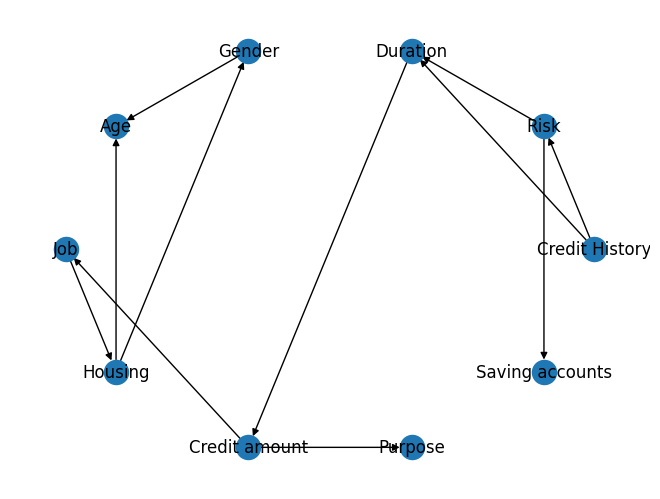

In [23]:
plot_bayesian_network(model)

**TODO 1.5**: The `estimate` method argument `tabu_length` controls how many of the last graph modifications are impossible to modify. Run another graph estimation while setting `tabu_length=1`. Is there any change to the graph?

  0%|          | 0/1000000 [00:00<?, ?it/s]

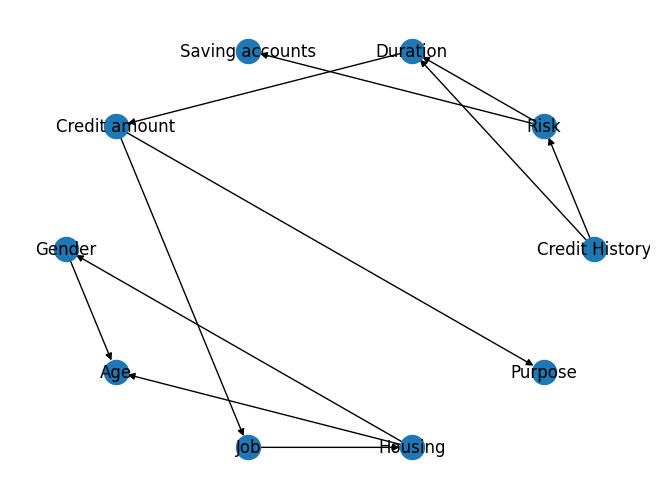

In [24]:
# TODO
model_tabu = hc.estimate(scoring_method=K2Score(train_set), tabu_length=1)
learned_network_tabu = pgmpy.models.BayesianNetwork(model_tabu.edges())

plot_bayesian_network(learned_network_tabu)


The graph remains the same, we have the same dependencies. The lack of change in the graph with tabu_length=1 indicates that the Hill Climb Search likely found an optimal or near-optimal solution early, and adding a small tabu list did not affect the outcome. However, this could change for larger datasets or more complex networks where cycling between suboptimal structures is more common.

***

**TODO 1.6**: As mentionned before, different scoring functions encode different beliefs of what an optimal graph would look like. Apply the `estimate` method with `bicscore` scoring method. The BIC (Bayesian Information Criterion) penalizes graphs with a lot of edges, under the belief that the simplest structure is the most likely (Occam's razor https://en.wikipedia.org/wiki/Occam%27s_razor).

  0%|          | 0/1000000 [00:00<?, ?it/s]

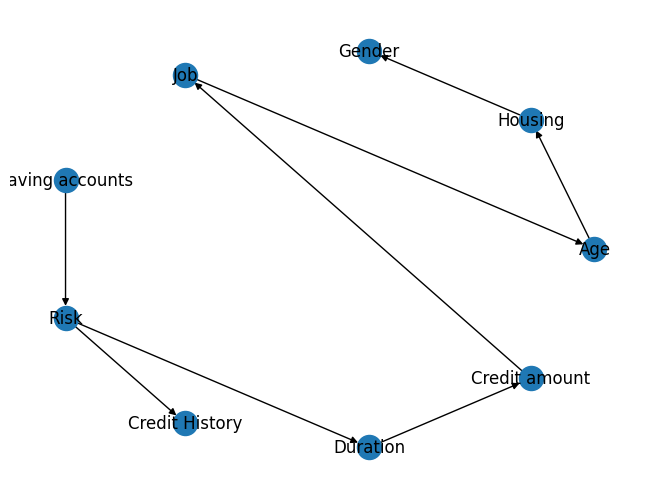

In [25]:
## TODO
from pgmpy.estimators import BicScore

# Step 2: Learn the structure using the K2 scoring function
model_bic = hc.estimate(scoring_method=BicScore(train_set))
learned_network_bic = pgmpy.models.BayesianNetwork(model_bic.edges())

plot_bayesian_network(learned_network_bic)

***
**Question** To your opinion, which graph is simpler to interpret?

&rarr; The estimate method with bicscore scoring method is the simpler graph to interpret. We indeed have fewer edges which refers to less dependencies between nodes.

**Question** To your opinion, which graph is faster to evaluate?

&rarr; More nodes and edges generally lead to more computational resources during evaluation and inference. This means, the estimate method with bicscore scoring method is also the faster graph to interpret.

**Conclusion:** <br>
In general, a simpler graph (with fewer edges) is typically both easier to interpret and faster to evaluate.

***

We will now use the graph produced by the `bicscore` method. We now need to learn a set of factor functions to model the joint probability distribution.
Precisely, for each node $V$ with parents (in-going edges) $Pa(V)$, we learn $\mathbb{P}(V|Pa(V))$.

The library pgmpy provides several parameter estimation algorithms, each with different particularities. The one we will use is the following:
 - Maximum Likelihood Estimation (https://pgmpy.org/param_estimator/mle.html): estimates joint probabilities by using the frequency/count of each configuration of values. It needs all variables to be observed in the data.

There are other methods, that do not apply to our case:
 - Expectation Maximization (https://pgmpy.org/param_estimator/em.html): Used in the presence of *latent* variables, i.e. variables in the graph for which there is no data. Expectation Maximization does not maximize the likelihood of the joint distribution, but the expectation of this likelihood.
 - Bayesian Estimation (https://pgmpy.org/param_estimator/bayesian_est.html): Used when domain knowledge, or belief, is known beside what is recorded in the data. This knowledge is specified to the algorithm in the form of *priors*. Due to the additional information, parameter estimates typically require less observations than Maximum Likelihood Estimation.




**TODO 1.7**: Apply MLE (https://pgmpy.org/param_estimator/mle.html) with its `.get_parameters()` method to estimate the parameters of the Bayesian Network. Add the parameters to a model object (class `pgmpy.models.BayesianNetwork`) built from the graph structure obtained with bicscore. You will name this model `model`. Use the training data only.

In [26]:
# TODO
from pgmpy.estimators import MaximumLikelihoodEstimator

estimator = MaximumLikelihoodEstimator(learned_network_bic, train_set)
parameters = estimator.get_parameters()
print(parameters)

# Add the parameters to the learned network model
for cpd in parameters:
    learned_network_bic.add_cpds(cpd)

[<TabularCPD representing P(Age:3 | Job:4) at 0x1eff0f8d050>, <TabularCPD representing P(Housing:3 | Age:3) at 0x1eff0f3f050>, <TabularCPD representing P(Job:4 | Credit amount:3) at 0x1eff127e290>, <TabularCPD representing P(Gender:2 | Housing:3) at 0x1eff0fb0650>, <TabularCPD representing P(Saving accounts:5) at 0x1eff0ee5810>, <TabularCPD representing P(Risk:2 | Saving accounts:5) at 0x1eff1289ed0>, <TabularCPD representing P(Credit amount:3 | Duration:3) at 0x1eff128aad0>, <TabularCPD representing P(Duration:3 | Risk:2) at 0x1eff12893d0>, <TabularCPD representing P(Credit History:5 | Risk:2) at 0x1eff0fa70d0>]


In [27]:
# RUN THIS CELL
assert learned_network_bic.check_model()

# Print the learned CPDs
for cpd in learned_network_bic.get_cpds():
    print(cpd)

+--------+--------+-----+---------------------+
| Job    | Job(0) | ... | Job(3)              |
+--------+--------+-----+---------------------+
| Age(0) | 0.35   | ... | 0.14492753623188406 |
+--------+--------+-----+---------------------+
| Age(1) | 0.2    | ... | 0.47101449275362317 |
+--------+--------+-----+---------------------+
| Age(2) | 0.45   | ... | 0.38405797101449274 |
+--------+--------+-----+---------------------+
+---------------+-----+---------------------+
| Age           | ... | Age(2)              |
+---------------+-----+---------------------+
| Housing(free) | ... | 0.19494584837545126 |
+---------------+-----+---------------------+
| Housing(own)  | ... | 0.6931407942238267  |
+---------------+-----+---------------------+
| Housing(rent) | ... | 0.11191335740072202 |
+---------------+-----+---------------------+
+---------------+-----+----------------------+
| Credit amount | ... | Credit amount(2)     |
+---------------+-----+----------------------+
| Job(0)     

## Part 2: Bayesian Inference

In this part, we will use the previous model to analyse the mechanisms behind Credit Risk attribution by banks.

We will first examine relations between `Gender` and `Risk`.

**TODO 2.1**: Use Variable Elimination to print the joint distribution $\mathbb{P}$(`Gender`,`Risk`). Use Variable Elimination to print the conditional distribution $\mathbb{P}$(`Risk`|`Gender`) for both Gender values.

In [28]:
# TODO
from pgmpy.inference import VariableElimination

# Instantiate
inference = VariableElimination(learned_network_bic)

# Joint distribution P(Gender, Risk)
joint_distribution = inference.query(variables=['Gender', 'Risk'])
print(f"Joint Distribution P(Gender, Risk): {joint_distribution}")

# Conditional distribution P(Risk | Gender)
risk_given_male = inference.query(variables=['Risk'], evidence={'Gender': 'male'})
risk_given_female = inference.query(variables=['Risk'], evidence={'Gender': 'female'})

print(risk_given_female)
print(risk_given_male)

Joint Distribution P(Gender, Risk): +----------------+------------+--------------------+
| Gender         | Risk       |   phi(Gender,Risk) |
+================+============+====================+
| Gender(female) | Risk(bad)  |             0.0946 |
+----------------+------------+--------------------+
| Gender(female) | Risk(good) |             0.2232 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(bad)  |             0.2032 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(good) |             0.4790 |
+----------------+------------+--------------------+
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2976 |
+------------+-------------+
| Risk(good) |      0.7024 |
+------------+-------------+
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2979 |
+------------+-------------+
| Risk(good) |      0.7021 |
+---

**Question**: Are gender differences associated to lowered risk? What is hidden in the conditional distribution, that is apparent in the joint distribution? What prior would be needed to deduce the joint distribution $\mathbb{P}$(`Gender`,`Risk`) from the conditional distributions $\mathbb{P}$(`Risk`|`Gender`)?

&rarr; Gender differences are indeed associated to lowered risk.
From the joint distribution, we can see that women have a lower probability than men of having a **bad risk**. (0.09 < 0.20) <br>
Thus, men are more likely to have a bad risk and women are more likely to have a good risk.

&rarr; The conditional distribution $\mathbb{P}$(`Risk`| `Gender`) tells us the probability of risk given gender, but it hides the **actual proportions of males and females** in the population.

&rarr; The joint distribution can be found by calculating: $\mathbb{P}$(`Gender`,`Risk`) = $\mathbb{P}$(`Risk`| `Gender`) * $\mathbb{P}$(`Gender`).

***

**TODO 2.2**: Examine how some of the other variables are associated to varying Risk (using conditional distributions). Write down your conclusions.

In [29]:
# TODO

# Conditional distribution P(Risk | Credit History = 0)
risk_given_credit_0 = inference.query(variables=['Risk'], evidence={'Credit History': 0})

# Conditional distribution P(Risk | Credit History = 1)
risk_given_credit_1 = inference.query(variables=['Risk'], evidence={'Credit History': 1})

# Conditional distribution P(Risk | Credit History = 2)
risk_given_credit_2 = inference.query(variables=['Risk'], evidence={'Credit History': 2})

# Print the results
print("P(Risk | Credit History = 0):")
print(risk_given_credit_0)

print("P(Risk | Credit History = 1):")
print(risk_given_credit_1)

print("P(Risk | Credit History = 2):")
print(risk_given_credit_2)


P(Risk | Credit History = 0):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.6486 |
+------------+-------------+
| Risk(good) |      0.3514 |
+------------+-------------+
P(Risk | Credit History = 1):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.5532 |
+------------+-------------+
| Risk(good) |      0.4468 |
+------------+-------------+
P(Risk | Credit History = 2):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3166 |
+------------+-------------+
| Risk(good) |      0.6834 |
+------------+-------------+


It tells that it has **higher bad risk** from people who has never had credits before than people who already have applied for a credit. The more people applied for credits, the fewer bad risks we have. 

In [30]:
# Conditional distribution P(Risk | Job)
risk_given_no_account = inference.query(variables=['Risk'], evidence={'Saving accounts': 'no account'})
risk_given_little = inference.query(variables=['Risk'], evidence={'Saving accounts': 'little'})
risk_given_moderate = inference.query(variables=['Risk'], evidence={'Saving accounts': 'little'})

print("P(Risk | Saving accounts = no account):")
print(risk_given_no_account)
print("P(Risk | Saving accounts = little):")
print(risk_given_little)
print("P(Risk | Saving accounts = moderate):")
print(risk_given_moderate)

P(Risk | Saving accounts = no account):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1677 |
+------------+-------------+
| Risk(good) |      0.8323 |
+------------+-------------+
P(Risk | Saving accounts = little):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3583 |
+------------+-------------+
| Risk(good) |      0.6417 |
+------------+-------------+
P(Risk | Saving accounts = moderate):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3583 |
+------------+-------------+
| Risk(good) |      0.6417 |
+------------+-------------+


It returns that we may have higher bad risks with people who have a saving account than those who never had. In the end, people who never applied for a credit seem more serious concerning their credit repayment.
***

**BONUS Question** Job categories go from "0 - unskilled" to "3 - highly skilled". Does the risk evolution in function of the Job attribute correspond to your expectations? If not, what could be the reason for the difference?

The Bayesian Network associated to german credit has 9 variables. The previous joint and conditional distribution only involve 2 of them. Therefore, the algorithm has eliminated 7 variables.

The computation time of the inference might change depending on the order in which variables are eliminated. The elimination order is controlled by the parameter `elimination_order` of the `.query` method.

**TODO 2.3** For an identical query of joint probability $\mathbb{P}(Risk, .)$ between the Risk and an arbitrary variable, measure the time spent when given different elimination orders (`greedy`, `MinFill`, `MinNeighbors`, `MinWeight`). You may use `time.time()` to obtain the current time.

In [31]:
# TODO
import time

arbitrary_variable = 'Credit amount'

# Measure time
elimination_orders = ['greedy', 'MinFill', 'MinNeighbors', 'MinWeight']
results = {}

for order in elimination_orders:
    start_time = time.time()
    
    joint_distribution = inference.query(variables=['Risk', arbitrary_variable], elimination_order=order)
    
    end_time = time.time()
    
    # Store the time
    results[order] = end_time - start_time

for order, duration in results.items():
    print(f"Time taken for elimination order '{order}': {duration:.6f} seconds")


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Time taken for elimination order 'greedy': 0.001004 seconds
Time taken for elimination order 'MinFill': 0.015575 seconds
Time taken for elimination order 'MinNeighbors': 0.012265 seconds
Time taken for elimination order 'MinWeight': 0.012517 seconds


The Bayesian Network can help us with *Feature Selection*. The goal of feature selection is to select a subset of variables that contain all the necessary information about `Risk`, i.e., the *Markov Blanket*.

For instance, variable `Job` might have information on `Risk` (i.e., not independent), but this information might already be contained in another variable, making `Job` redundant.

**TODO 2.4** To know which variables can be made independent from `Risk` by conditioning on other variables, it is possible to use the graph structure. Find a Markov Blanket of `Risk`. The method `BayesianNetwork.get_markov_blanket` (https://pgmpy.org/base/base.html) is ready made for this task.

In [32]:
## TODO

# Markov Blanket of the variable 'Risk'
risk_markov_blanket = learned_network_bic.get_markov_blanket('Risk')

# Print the Markov Blanket
print("Markov Blanket of 'Risk':")
print(risk_markov_blanket)

Markov Blanket of 'Risk':
['Duration', 'Saving accounts', 'Credit History']


**Question** Interpret the markov blanket information: what is a markov blanket and what does it mean regarding how banks attribute credit risk rating?

&rarr; A Markov Blanket represents the set of variables that renders a particular variable conditionally independent from all other variables in the network. the Markov Blanket gives information on the parents (direct causes), children (direct effects) and the other parents of its children (variables that influence its children). <br>
Here, the Markov Blanket of Risk includes the variables **Duration**, **Saving acocunts** and **Credit History**. These three variables contain all the necessary information to predict or influence the Risk rating in the Bayesian network. Once we know the values of Duration, Saving accounts, and Credit History, the variable Risk becomes conditionally independent of all other variables in the model.

#### BONUS: causal inference

**This bonus part covers an application of Bayesian Network not covered during the CM. You may go to part 3 directly then come back to it later.**

We will now consider the variable `Job`, for which we observe that Risk is different depending on the category. We can say clearly that Job and Risk aren't **independent**. What we cannot say while looking uniquely at the conditional probability distribution, is whether `Job` influences (is a cause of) `Risk`. Indeed, variables can be associated but not causated.

It is generally difficult to determine causal relationships from observed data. Assuming that causal effects are *linear* (meaning that if `Job` has an influence on `Risk`, then this influence can be correctly modeled by a linear regression model), the causal inference framework (https://pgmpy.org/exact_infer/causal.html) allows to estimate whether two associated variables have a causal influence on each other (Average Treatement Effect https://en.wikipedia.org/wiki/Average_treatment_effect). The question it solves is the following: "if a credit seeker's job category were to increase due to a job change, how much would Risk increase?"

Precisely, the ATE is the difference between the expected Risk when the job stays the same, compared to the expected Risk when the job category increases.

**TODO 2.6**: Apply `pgmpy.inference.CausalInference` with its method `.estimate_ate` on training data, to infer if `Job` has an influence on `Risk`.

**Question**: Is Job category causaly linked to Risk?

We now consider the variable `Duration`. We can confirm that it is associated to `Risk`, with higher credit amount related to greater proportion of 'bad' risk. Again, we would like to know if this is a cause-effect relation.

We will now use another way of quantifying causal relationships: *do-calculus* with *counterfactuals*. The question it solves is: "if all credit seekers were to be attributed the same duration by the bank, how would risk be distributed?" If Duration and Risk are not causaly linked, then the resulting distribution of Risk will be identical for all durations.

**TODO 2.7**: Use `CausalInference.query` to estimate the Risk after a do operation on Duration for each category of duration (specify `do={"Duration":value}` for appropriate values).


In [33]:
#TODO


**Question**: Is Duration causaly linked to Risk?

## Part 3: Bayesian models as predictive models

Now that we have learned a model of the training data, we can apply it to validation data to evaluate how it works as a predictive model. We can use Maximum A Posteriori inference, to find out what Risk is most likely considering the values of the other variables. Formally, for a given validation sample $s$ where Risk is removed, we want to estimate $\arg \max \mathbb{P}(Risk | Gender,...,Housing=s)$.

**TODO 3.1**: Use `VariableElimination.map_query` (https://pgmpy.org/exact_infer/ve.html) to predict and store credit risk for each sample in the validation set. You can iterate over samples by using `val_set.to_dict()`, each row being converted to a dictionary. Make sure to not include `Risk` in the evidences.

You will need to store the true risk in a list `y_true` for each sample, and store the corresponding predicted value into a list `y_pred`.

Variables in the BN: ['Credit History', 'Age', 'Gender', 'Job', 'Housing', 'Saving accounts', 'Credit amount', 'Duration', 'Purpose', 'Risk']


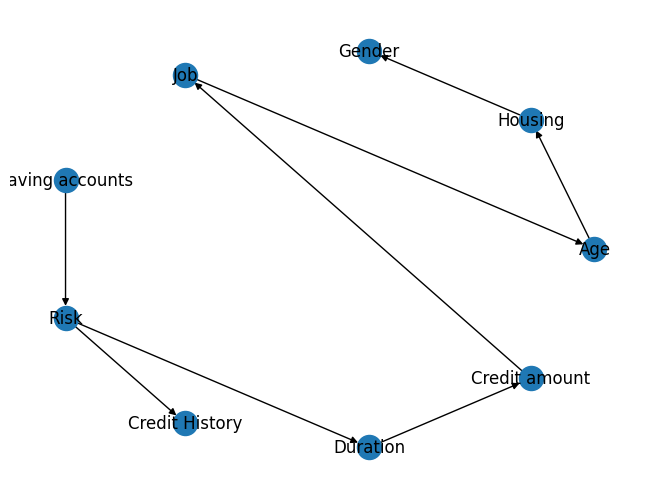

In [34]:
print("Variables in the BN:", model.nodes())
plot_bayesian_network(learned_network_bic)

Run the next cell to visualize the classification performance.

In [35]:
# RUN THIS CELL
# Initialize the inference object
inference = VariableElimination(learned_network_bic)

# Initialize lists to store true and predicted risks
y_true, y_pred = [], []

# Iterate over each sample in the validation set
for sample in val_set.to_dict(orient='records'):
    # Store the true Risk value
    y_true.append(sample['Risk'])

    # Prepare the evidence by excluding 'Risk'
    evidence = {key: value for key, value in sample.items() if key != 'Risk' and key in learned_network_bic.nodes()}

    # Perform MAP query to predict the most likely value for 'Risk'
    predicted_risk = inference.map_query(variables=['Risk'], evidence=evidence)
    
    # Append the predicted risk to y_pred
    y_pred.append(predicted_risk['Risk'])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Classification accuracy: 0.67


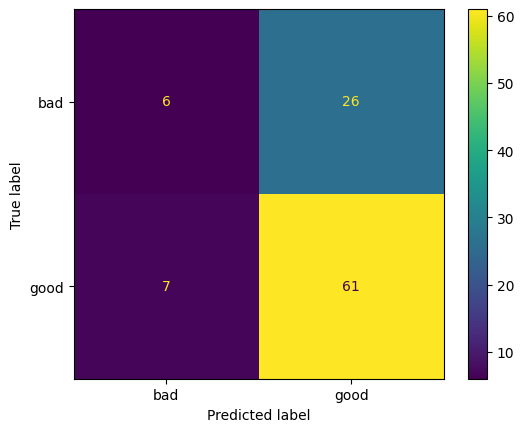

In [36]:
# RUN THIS CELL

print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**Question** The previous snipet plots a Confusion Matrix. Briefly explain what it means. <br>
&rarr; The confusion matrix visualizes the performance of a classification model by displaying the number of correct and incorrect predictions across different classes. (FP, FN, TP,TN). Here, True positives, on bottom right (good predicted as good) – The model correctly predicted 61 instances as "good."

**Question** What is the link between the confusion matrix and the accuracy metric? <br>

&rarr;
Accuracy is given by Accuracy = (True postives + True negatives)/(Total number of predictions)
***

**Question** What would be False Positive and False Negative in this confusion matrix? Which one would you rather minimize if you were to work for a bank?

&rarr;
The model predicted "good" risk when the actual risk was "bad". There are 26 false positives (top right). This means that the bank would approve a credit, assuming the person is a good risk, but the person is actually a bad risk and more likely to default on the loan. This could lead to financial losses for the bank.
<br>
The model predicted "bad" risk when the actual risk was "good". There are 7 false negative (bottom left). This means that the bank would reject a loan, assuming the person is a bad risk, but the person is actually a good risk. This could lead to a missed opportunity for profit, as the bank would lose a reliable customer.

***

We would like to compare the previous map_query predictive model to a standard machine learning model.

We will use XGBoost, one of the main libraries of simple learning models based on "boosting" and specifically "gradient boosting" (https://xgboost.readthedocs.io/en/stable/).


XGBoost is a library that can only manipulate numerical values. Columns "Gender", "Housing", "Saving accounts", "Purpose", and "Risk" contain strings, so we need to transform them. For each of these columns, the next cell creates a new column with suffix "_numerical" (i.e. "Gender_numerical"), where each of the string values is replaced by an integer. This can be done with `.apply`
(https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) and a function, or `.map` (https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) and a dictionary.


In [56]:
from sklearn.tree import DecisionTreeClassifier

full_variables = ["Purpose_numerical", "Saving accounts_numerical", "Housing_numerical", "Gender_numerical", "Credit History", "Age", "Job", "Credit amount", "Duration"]

# Separate features and target variable
X_train = train_set[full_variables]
y_train = train_set['Risk_numerical']

# Train the model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)


DecisionTreeClassifier()

In [57]:
# Run this cell.

#method 1
label_mapping = {'good': 0, 'bad': 1}
val_set['Risk_numerical'] = val_set['Risk'].map(label_mapping)
train_set['Risk_numerical'] = train_set['Risk'].map(label_mapping)

#method 2
label_mapping = dict([(value,index) for index,value in enumerate(german_credit["Gender"].unique())])
val_set['Gender_numerical'] = val_set['Gender'].map(label_mapping)
train_set['Gender_numerical'] = train_set['Gender'].map(label_mapping)

#method 3
label_mapping = lambda x: german_credit["Housing"].unique().tolist().index(x)
val_set['Housing_numerical'] = val_set['Housing'].apply(label_mapping)
train_set['Housing_numerical'] = train_set['Housing'].apply(label_mapping)

label_mapping = lambda x: german_credit["Saving accounts"].unique().tolist().index(x)
val_set['Saving accounts_numerical'] = val_set['Saving accounts'].apply(label_mapping)
train_set['Saving accounts_numerical'] = train_set['Saving accounts'].apply(label_mapping)

label_mapping = lambda x: german_credit["Purpose"].unique().tolist().index(x)
val_set['Purpose_numerical'] = val_set['Purpose'].apply(label_mapping)
train_set['Purpose_numerical'] = train_set['Purpose'].apply(label_mapping)

Run the next cell. Its purpose is to make XGBoost and Pandas aware of the categorical nature of some columns.

In [58]:
##  Run this cell.
# Make sure that the column names correspond.

train_set['Purpose_numerical'] = train_set['Purpose_numerical'].astype("category")
val_set['Purpose_numerical'] = val_set['Purpose_numerical'].astype("category")
train_set['Saving accounts_numerical'] = train_set['Saving accounts_numerical'].astype("category")
val_set['Saving accounts_numerical'] = val_set['Saving accounts_numerical'].astype("category")
train_set['Housing_numerical'] = train_set['Housing_numerical'].astype("category")
val_set['Housing_numerical'] = val_set['Housing_numerical'].astype("category")
train_set['Gender_numerical'] = train_set['Gender_numerical'].astype("category")
val_set['Gender_numerical'] = val_set['Gender_numerical'].astype("category")
train_set['Risk_numerical'] = train_set['Risk_numerical'].astype("category")
val_set['Risk_numerical'] = val_set['Risk_numerical'].astype("category")
train_set['Duration'] = train_set['Duration'].astype("category")
val_set['Duration'] = val_set['Duration'].astype("category")
train_set['Age'] = train_set['Age'].astype("category")
val_set['Age'] = val_set['Age'].astype("category")
train_set['Credit amount'] = train_set['Credit amount'].astype("category")
val_set['Credit amount'] = val_set['Credit amount'].astype("category")

**TODO 3.2** In the next cell, create an XGBClassifier model (https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) with adequate parameter values. Train (`.fit`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.fit) on `train_set` with the columns `full_variables` to predict "Risk_numerical". Predict (`.predict`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.predict) on the validation set `val_set`, and store the result as `y_pred`.

Hint: for categorical values to be handled, a parameter "enable_categorical" must be set to true at model declaration.

In [59]:
full_variables = ["Purpose_numerical", "Saving accounts_numerical", "Housing_numerical", "Gender_numerical", "Credit History", "Age", "Job", "Credit amount", "Duration"]

## WRITE YOUR CODE BELOW
X_val = val_set[full_variables]

# Make predictions
y_pred = model.predict(X_val)

Run the next cell to evaluate the performance of the model.

Classification accuracy: 0.61


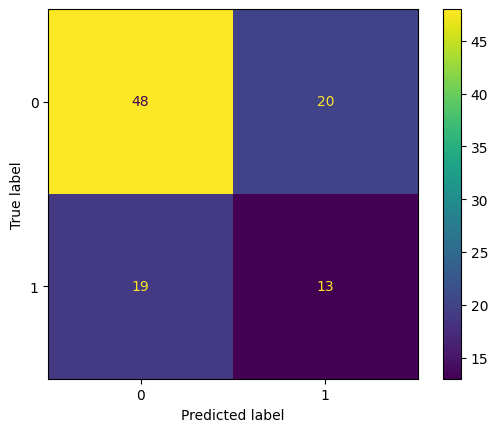

In [60]:
y_true = val_set["Risk_numerical"].values
print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**TODO 3.3** Train and evaluate another XGBClassifier, this time with input data restricted to the markov blanket found in TODO 2.4.

Classification accuracy: 0.69


c:\Users\jack0\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


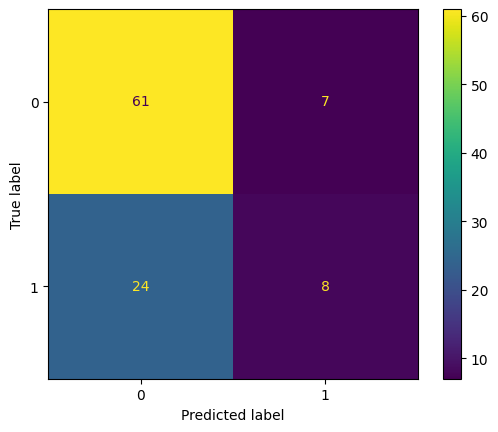

In [63]:
## WRITE YOUR CODE BELOW
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Markov blanket variables
markov_blanket_variables = ['Duration', 'Saving accounts_numerical', 'Credit History']

# Convert categorical columns to their integer codes
train_set['Duration'] = train_set['Duration'].cat.codes
val_set['Duration'] = val_set['Duration'].cat.codes

train_set['Saving accounts_numerical'] = train_set['Saving accounts_numerical'].cat.codes
val_set['Saving accounts_numerical'] = val_set['Saving accounts_numerical'].cat.codes

# Prepare the training and validation sets with only Markov blanket features
X_train_mb = train_set[markov_blanket_variables]
y_train_mb = train_set['Risk_numerical']

X_val_mb = val_set[markov_blanket_variables]
y_val_mb = val_set['Risk_numerical']

# Instantiate the XGBClassifier
xgb_model_mb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model on the Markov blanket features
xgb_model_mb.fit(X_train_mb, y_train_mb)

# Make predictions on the validation set
y_pred_mb = xgb_model_mb.predict(X_val_mb)

# Print classification accuracy
print("Classification accuracy:", accuracy_score(y_val_mb, y_pred_mb))

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val_mb, y_pred_mb)


**Question**: Conclude: did removing columns decrease the information on Risk contained by the dataset? Was this an expected behaviour? <br>

&rarr; Removing the columns based on the Markov blanket did likely reduce the information available for predicting "Risk". <br> 
The Markov blanket includes only the directly relevant features, but it does not retain all information that might indirectly help the prediction. The performance seems weaker, as reflected by the higher number of misclassifications (e.g., 24 false negatives and 7 false positives).
<br>
This outcome was expected to some extent because, while the Markov blanket conceptually includes the most relevant variables for predicting the target, in practice, other features may still contribute to prediction through more complex relationships. We anticipated a drop in performance when fewer features are used.

**Question**: Did removing column increase accuracy? Suggest an explanation why. <br>
&rarr; Yes, removing columns did **increase a bit the accuracy**. The Markov blanket model has fewer, more relevant features, leading to potentially less noise and better generalization. The full feature set model could likely suffer from noise, redundant features, and possibly overfitting, which reduces its accuracy.

**Question**: Conclude on the predictive performance of bayesian modeling versus XGBoost for this dataset.<br> 
&rarr; Bayesian approaches, which focus on probabilistic dependencies like the Markov blanket, are highly interpretable and mathematically rigorous. They identify the most direct predictors based on statistical relationships. However, for complex datasets with intricate feature interactions or noisy data, Bayesian models may underperform if only direct dependencies are considered.

&rarr; On the other hand, XGBoost, a tree-based boosting algorithm, excels at capturing non-linear relationships and interactions between features. Based on the confusion matrices, the XGBoost model with all features outperforms the Bayesian approach (Markov blanket) in our use case here, demonstrating its superior predictive power on this dataset.